**RECIPES MODEL**

We utilized the URLs provided to access the datasets stored in the folder https://raw.githubusercontent.com/MattRamb97/Erasmus_Hardgainers/main/Datasets/

using the pandas library. Subsequently, we identified an issue in the 'ingredients' column of the three datasets, characterized by the presence of the word 'ADVERTISEMENT', which we proceeded to remove. Additionally, we printed information regarding one of the datasets (the same information applies to the others) and their respective shapes. We extracted the coloumns for title, ingredients and instructions, leaving outside the pictures links. Since the computation time was to high also for one dataset, we used only the recipes_raw_nosource_ar.json .

In [1]:
!pip install pandas
import sys
url_1 = 'https://raw.githubusercontent.com/MattRamb97/Erasmus_Hardgainers/main/Datasets/recipes_raw_nosource_ar.json'
url_2 = 'https://raw.githubusercontent.com/MattRamb97/Erasmus_Hardgainers/main/Datasets/recipes_raw_nosource_epi.json'
url_3 = 'https://raw.githubusercontent.com/MattRamb97/Erasmus_Hardgainers/main/Datasets/recipes_raw_nosource_fn.json'

import pandas as pd
df_ar = pd.read_json(url_1, orient='records', dtype='dict').transpose()
df_ar.info()
print()

df_ar = df_ar.dropna(subset=['title', 'ingredients', 'instructions', 'picture_link'])

df_ar['title'] = df_ar['title'].astype(str)

# Remove the word 'ADVERTISEMENT' from each text entry in the 'ingridients'
df_ar['ingredients'] = df_ar['ingredients'].astype(str).str.replace('ADVERTISEMENT', '',regex=True)

df_ar['instructions'] = df_ar['instructions'].astype(str)

print('From AR:', df_ar.shape)


[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
<class 'pandas.core.frame.DataFrame'>
Index: 39802 entries, rmK12Uau.ntP510KeImX506H6Mr6jTu to 2Q3Zpfgt/PUwn1YABjJ5A9T3ZW8xwVa
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   title         39522 non-null  object
 1   ingredients   39522 non-null  object
 2   instructions  39522 non-null  object
 3   picture_link  39522 non-null  object
dtypes: object(4)
memory usage: 2.5+ MB

From AR: (39522, 4)


We applied a series of pip commands, for setting up the Python environment for our project. Here’s an explanation of each command and what it does:

- !pip install accelerate: installs the accelerate library from Hugging Face. This library simplifies running machine learning models on multi-GPU, making it easier to scale up computations without deeply modifying the code.
- !pip install -i https://pypi.org/simple/ bitsandbytes: installs the bitsandbytes library. This is particularly useful for training neural networks with reduced memory footprint on NVIDIA GPUs. It's often used to optimize large model training by using 8-bit optimizers.
- !pip install -q -U git+https://github.com/huggingface/transformers.git: installs the latest version of the transformers library directly from its GitHub repository. The transformers library provides a wide range of pre-trained models for NLP tasks.
- !pip install -q -U git+https://github.com/huggingface/peft.git: Installs the peft library, which stands for Pipeline Efficient Fine-Tuning. This library is part of Hugging Face's ecosystem, designed to improve the efficiency and scalability of fine-tuning large transformer models.
- !pip install -q -U git+https://github.com/huggingface/accelerate.git: this command aims to install the latest version from the GitHub source.
- !pip install -q -U datasets scipy ipywidgets matplotlib: installs multiple useful Python libraries: datasets, used for easily loading and manipulating datasets; scipy: fundamental library for scientific computing with Python, providing modules for optimization, linear algebra, integration, and statistics; ipywidgets: allows interactive HTML widgets for the Jupyter notebook and the IPython kernel; matplotlib: a plotting library for Python, providing a means of making high-quality graphs, charts, figures, etc.

In [2]:
!pip install accelerate
!pip install -i https://pypi.org/simple/ bitsandbytes
!pip install -q -U git+https://github.com/huggingface/transformers.git
!pip install -q -U git+https://github.com/huggingface/peft.git
!pip install -q -U git+https://github.com/huggingface/accelerate.git
!pip install -q -U datasets scipy ipywidgets matplotlib


[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Looking in indexes: https://pypi.org/simple/

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


Create a formatting_func to structure training examples as prompts.

In [3]:
def formatting_func(title, ingredients, instructions):
    text = f"### Title: {title}\n ### Ingredients: {ingredients}\n ### Instructions: {instructions}"
    return text

Load Mistral - mistralai/Mistral-7B-v0.1

In [4]:
#!huggingface-cli login
from huggingface_hub import notebook_login

notebook_login()

import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "mistralai/Mistral-7B-v0.1"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(base_model_id, quantization_config=bnb_config, device_map="auto")

/home/ubuntu/.pyenv/versions/3.10.14/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/home/ubuntu/.pyenv/versions/3.10.14/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Set up the tokenizer. Add padding on the left as it makes training use less memory. For model_max_length, it's helpful to get a distribution of our data lengths. Let's first tokenize without the truncation/padding, so we can get a length distribution.

In [5]:
tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    padding_side="left",
    add_eos_token=True,
    add_bos_token=True,
)
tokenizer.pad_token = tokenizer.eos_token

def generate_and_tokenize_prompt(title, ingredients, instructions):
    return tokenizer(formatting_func(title, ingredients, instructions))

Reformat the prompt and tokenize each sample.

In [6]:
tokenized_titles = []
tokenized_ingredients = []
tokenized_instructions = []

for title, ingredients, instructions in zip(df_ar['title'].iloc[:200], df_ar['ingredients'].iloc[:200], df_ar['instructions'].iloc[:200]):
    tokenized_titles.append(generate_and_tokenize_prompt(title, ingredients, instructions))
    tokenized_ingredients.append(generate_and_tokenize_prompt(title, ingredients, instructions))
    tokenized_instructions.append(generate_and_tokenize_prompt(title, ingredients, instructions))

Let's get a distribution of our dataset lengths, so we can determine the appropriate max_length for our input tensors.

400


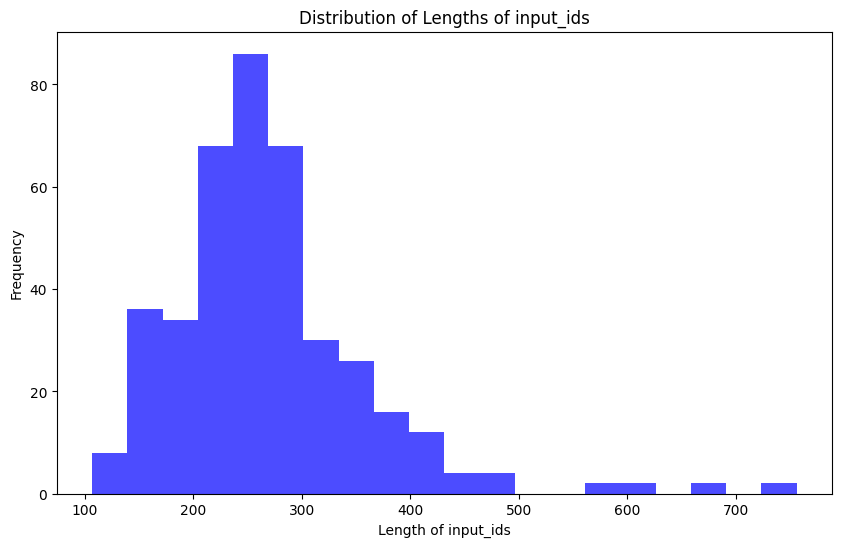

In [7]:
import matplotlib.pyplot as plt

def plot_data_lengths(tokenized_titles, tokenized_ingredients):
    lengths = [len(x['input_ids']) for x in tokenized_titles]
    lengths += [len(x['input_ids']) for x in tokenized_ingredients]
    print(len(lengths))

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    plt.show()

plot_data_lengths(tokenized_titles, tokenized_ingredients)

In [8]:
max_length = 365  # This was an appropriate max length for our dataset

def generate_and_tokenize_prompt2(title, ingredients, instructions):
    title_result = tokenizer(
        title,
        truncation=True,
        max_length=max_length,
        padding="max_length",
    )
    ingredients_result = tokenizer(
        ingredients,
        truncation=True,
        max_length=max_length,
        padding="max_length",
    )
    instructions_result = tokenizer(
        instructions,
        truncation=True,
        max_length=max_length,
        padding="max_length",
    )

    title_result["labels"] = title_result["input_ids"].copy()
    ingredients_result["labels"] = ingredients_result["input_ids"].copy()
    instructions_result["labels"] = title_result["input_ids"].copy()

    return title_result, ingredients_result, instructions_result

# Tokenization of the dataset
tokenized_data = []
for title, ingredients, instructions in zip(df_ar['title'].iloc[:200], df_ar['ingredients'].iloc[:200], df_ar['instructions'].iloc[:200]):
    title_result, ingredients_result, instructions_result = generate_and_tokenize_prompt2(title, ingredients, instructions)
    # Concatenating results into a single input
    combined_input_ids = title_result["input_ids"] + ingredients_result["input_ids"] + instructions_result["input_ids"]
    combined_labels = title_result["labels"] + ingredients_result["labels"] + instructions_result["labels"]
    tokenized_data.append({'input_ids': combined_input_ids, 'labels': combined_labels})

# Split data into training and evaluation datasets
split_index = int(0.8 * len(tokenized_data))
train_dataset = tokenized_data[:split_index]
eval_dataset = tokenized_data[split_index:]


Generates a recipe text using the pre-trained language model Mistral. It formats a prompt with a title, ingredients, and instructions, then tokenizes this input for the model. The model runs on a GPU, generating text under constraints to avoid repetition and limit output size. Finally, it decodes and prints the generated recipe, demonstrating the model's capability to create contextually relevant and creative content.

In [10]:
eval_prompt = f"### Title: {title}\n ### Ingredients: {ingredients}\n ### Instructions: {instructions}"

# Init an eval tokenizer that doesn't add padding or eos token
eval_tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    add_bos_token=True,
)

model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(model.generate(**model_input, max_new_tokens=256, repetition_penalty=1.15)[0], skip_special_tokens=True))


/home/ubuntu/.pyenv/versions/3.10.14/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


### Title: Classic Waffles
 ### Ingredients: ['2 cups all-purpose flour ', '1 teaspoon salt ', '4 teaspoons baking powder ', '2 tablespoons white sugar ', '2 eggs ', '1 1/2 cups warm milk ', '1/3 cup butter, melted ', '1 teaspoon vanilla extract ', '']
 ### Instructions: In a large bowl, mix together flour, salt, baking powder and sugar; set aside. Preheat waffle iron to desired temperature.
In a separate bowl, beat the eggs. Stir in the milk, butter and vanilla. Pour the milk mixture into the flour mixture; beat until blended.
Ladle the batter into a preheated waffle iron. Cook the waffles until golden and crisp. Serve immediately.
### Source: https://www.allrecipes.com/recipe/20789/classic-waffles/

### Title: Chocolate Chip Cookie Dough Ice Cream
 ### Ingredients: ['1 (16 ounce) package refrigerated chocolate chip cookie dough ', '1 quart vanilla ice cream ', '1/2 cup hot fudge sauce ', '1/2 cup caramel sundae syrup ',]
 ### Instructions: Cut cookie dough into small pieces. Place ha



---



**SET UP LORA**

Now, to start our fine-tuning, we have to apply some preprocessing to the model to prepare it for training. For that use the prepare_model_for_kbit_training method from PEFT.

In [11]:
from peft import prepare_model_for_kbit_training

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

Prints the number of trainable parameters in the model.

In [12]:
def print_trainable_parameters(model):
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

Let's print the model to examine its layers, as we will apply QLoRA to all the linear layers of the model. Those layers are q_proj, k_proj, v_proj, o_proj, gate_proj, up_proj, down_proj, and lm_head.

In [13]:
print(model)

MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralSdpaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): MistralRotaryEmbedding()
        )
        (mlp): MistralMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): MistralRMSNorm()
        (post_attention_layernorm): MistralRMSNorm()
      )
    )

Here we define the LoRA config.

- r: is the rank of the low-rank matrix used in the adapters, which thus controls the number of parameters trained. A higher rank will allow for more expressivity, but there is a compute tradeoff.

- alpha: is the scaling factor for the learned weights. The weight matrix is scaled by alpha/r, and thus a higher value for alpha assigns more weight to the LoRA activations.

The values used in the QLoRA paper were r=64 and lora_alpha=16, and these are said to generalize well, but we will use r=32 and lora_alpha=64 so that we have more emphasis on the new fine-tuned data while also reducing computational complexity.

In [14]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=32,
    lora_alpha=64,
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
        "lm_head",
    ],
    bias="none",
    lora_dropout=0.05,  # Conventional
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

trainable params: 85041152 || all params: 3837112320 || trainable%: 2.2162799758751914


See how the model looks different now, with the LoRA adapters added:

In [15]:
print(model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): MistralForCausalLM(
      (model): MistralModel(
        (embed_tokens): Embedding(32000, 4096)
        (layers): ModuleList(
          (0-31): 32 x MistralDecoderLayer(
            (self_attn): MistralSdpaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=32, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=32, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): lora.Linear4bit(
                (base_layer):



---



**TRAINING THE MODEL**

In [16]:
if torch.cuda.device_count() > 1: # If more than 1 GPU
    model.is_parallelizable = True
    model.model_parallel = True

In [17]:
from accelerate import FullyShardedDataParallelPlugin, Accelerator
from torch.distributed.fsdp.fully_sharded_data_parallel import FullOptimStateDictConfig, FullStateDictConfig

fsdp_plugin = FullyShardedDataParallelPlugin(
    state_dict_config=FullStateDictConfig(offload_to_cpu=True, rank0_only=False),
    optim_state_dict_config=FullOptimStateDictConfig(offload_to_cpu=True, rank0_only=False),
)

accelerator = Accelerator(fsdp_plugin=fsdp_plugin)

model = accelerator.prepare_model(model)

In [19]:
!pip install -q wandb -U

import wandb, os
wandb.login()

wandb_project = "journal-finetune"
if len(wandb_project) > 0:
    os.environ["WANDB_PROJECT"] = wandb_project

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


wandb: Currently logged in as: matteo-rambaldi (recipes_model). Use `wandb login --relogin` to force relogin


In [20]:
import transformers
from datetime import datetime

project = "recepies-model_v1"
base_model_name = "mistral"
run_name = base_model_name + "-" + project
output_dir = "./" + run_name

import transformers
from transformers import TrainingArguments, Trainer
from datetime import datetime
import torch

# Initialize Trainer with your model and tokenizer
trainer = Trainer(
    model=model,
    args=TrainingArguments(
        output_dir='./output',
        warmup_steps=1,
        per_device_train_batch_size=2,
        gradient_accumulation_steps=1,
        gradient_checkpointing=True,
        max_steps=500,
        learning_rate=2.5e-5,
        fp16=True,
        optim="paged_adamw_8bit",
        logging_steps=25,
        logging_dir="./logs",
        save_strategy="steps",
        save_steps=25,
        evaluation_strategy="steps",
        eval_steps=25,
        do_eval=True,
        report_to="wandb",
        run_name=f"{run_name}-{datetime.now().strftime('%Y-%m-%d-%H-%M')}"
    ),
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)
model.config.use_cache = False
trainer.train()

/home/ubuntu/.pyenv/versions/3.10.14/lib/python3.10/site-packages/transformers/training_args.py:1463: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
max_steps is given, it will override any value given in num_train_epochs


/home/ubuntu/.pyenv/versions/3.10.14/lib/python3.10/site-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/home/ubuntu/.pyenv/versions/3.10.14/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss
25,3.195900,0.754381
50,0.674900,0.688768
75,0.625500,0.665725
100,0.484700,0.675880
125,0.438000,0.679773
150,0.474000,0.672880
175,0.395200,0.752642
200,0.306100,0.720806
225,0.294100,0.737986
250,0.262000,0.835111


/home/ubuntu/.pyenv/versions/3.10.14/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/ubuntu/.pyenv/versions/3.10.14/lib/python3.10/site-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/home/ubuntu/.pyenv/versions/3.10.14/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 

TrainOutput(global_step=500, training_loss=0.40627877569198606, metrics={'train_runtime': 989.7316, 'train_samples_per_second': 1.01, 'train_steps_per_second': 0.505, 'total_flos': 4.727575719936e+16, 'train_loss': 0.40627877569198606, 'epoch': 6.25})



---



**TRY THE TRAINED MODEL**

In [21]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "mistralai/Mistral-7B-v0.1"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,  # Mistral, same as before
    quantization_config=bnb_config,  # Same quantization config as before
    device_map="auto",
    trust_remote_code=True,
)

eval_tokenizer = AutoTokenizer.from_pretrained(base_model_id, add_bos_token=True, trust_remote_code=True)

/home/ubuntu/.pyenv/versions/3.10.14/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [23]:
from peft import PeftModel

ft_model = PeftModel.from_pretrained(base_model, "output/checkpoint-275")

In [38]:
eval_prompt = f"### Ingredients: {df_ar['ingredients'].iloc[102]}\n### Generate Title and Instructions:\n### Title:"
#f"Title: {df_ar['title'].iloc[102]} ### Expected Output: ### Ingredients: "
model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    generated_texts = eval_tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=100, repetition_penalty=1.15)[0], skip_special_tokens=True)
    print(generated_texts)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


### Ingredients: ['MEATBALLS ', '1 pound lean ground beef ', '1 cup fresh bread crumbs ', '1 tablespoon dried parsley ', '1 tablespoon grated Parmesan cheese ', '1/4 teaspoon ground black pepper ', '1/8 teaspoon garlic powder ', '1 egg, beaten ', 'SAUCE ', '3/4 cup chopped onion ', '5 cloves garlic, minced ', '1/4 cup olive oil ', '2 (28 ounce) cans whole peeled tomatoes ', '2 teaspoons salt ', '1 teaspoon white sugar ', '1 bay leaf ', '1 (6 ounce) can tomato paste ', '3/4 teaspoon dried basil ', '1/2 teaspoon ground black pepper ', '']
### Generate Title and Instructions:
### Title: Meatballs in Tomato Sauce
### Instructions:
'Preheat oven to 375 degrees F (190 degrees C).
Coat a large baking sheet with non-stick spray.
In a medium bowl, combine the ground beef, bread crumbs, parsley, Parmesan, pepper, garlic powder and beaten egg. Mix well, and form into 1 inch meatballs. Place the meatballs onto the prepared




---



**EVALUATION WITH METRICS**

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


/home/ubuntu/.pyenv/versions/3.10.14/lib/python3.10/site-packages/datasets/load.py:759: FutureWarning: The repository for bleu contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.0/metrics/bleu/bleu.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
/home/ubuntu/.pyenv/versions/3.10.14/lib/python3.10/site-packages/datasets/load.py:759: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.0/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be

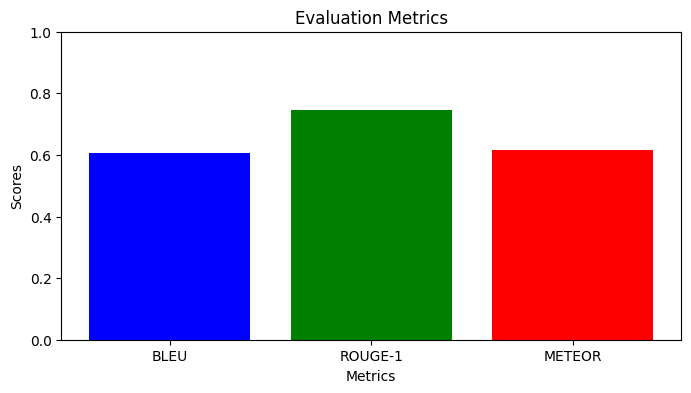

In [39]:
!pip install rouge_score
import matplotlib.pyplot as plt

def evaluate_and_plot(generated_text, reference_text):
    from datasets import load_metric
    bleu_metric = load_metric('bleu')
    rouge_metric = load_metric('rouge')
    meteor_metric = load_metric('meteor')

    predictions = [generated_text.split()]
    references = [[reference_text.split()]]

    # Compute metrics
    bleu_result = bleu_metric.compute(predictions=predictions, references=references)['bleu']
    rouge_result = rouge_metric.compute(predictions=[generated_text], references=[reference_text])['rouge1'].mid.fmeasure
    meteor_result = meteor_metric.compute(predictions=[generated_text], references=[reference_text])['meteor']

    # Prepare data for plotting
    metrics = ['BLEU', 'ROUGE-1', 'METEOR']
    scores = [bleu_result, rouge_result, meteor_result]

    # Plotting
    plt.figure(figsize=(8, 4))
    plt.bar(metrics, scores, color=['blue', 'green', 'red'])
    plt.xlabel('Metrics')
    plt.ylabel('Scores')
    plt.title('Evaluation Metrics')
    plt.ylim(0, 1)  # Assuming the scores are normalized between 0 and 1
    plt.show()

# Example generated and reference texts
reference_texts = f"### Ingredients: {df_ar['ingredients'].iloc[102]}\n### Generate Title and Instructions:\n### Title:{df_ar['title'].iloc[102]}\nInstrictions:{df_ar['instructions'].iloc[102]}"

#f"Title: {df_ar['title'].iloc[102]} ### Expected Output: ### Ingredients: {df_ar['ingredients'].iloc[102]} ### Instructions: {df_ar['instructions'].iloc[102]}"


# Generate plot
evaluate_and_plot(generated_texts, reference_texts)